In [ ]:
# import packages

import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# read in data

batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats),
                                   transforms.Grayscale(num_output_channels=1)])

train_ds = torchvision.datasets.ImageFolder(root="../content/drive/MyDrive/Junior Year/Spring/IW06/Code and Files/Collections",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
print(len(train_ds))

128


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=16).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

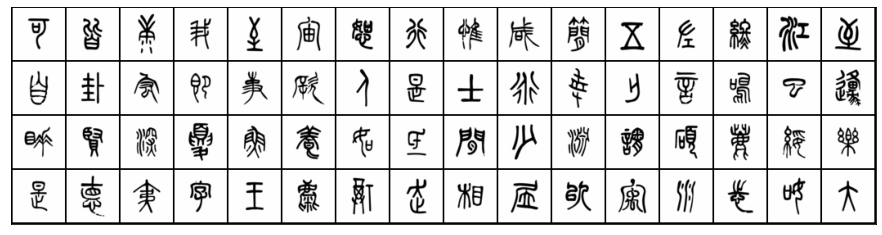

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 1 x 512 x 512

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 1, 64, 64])


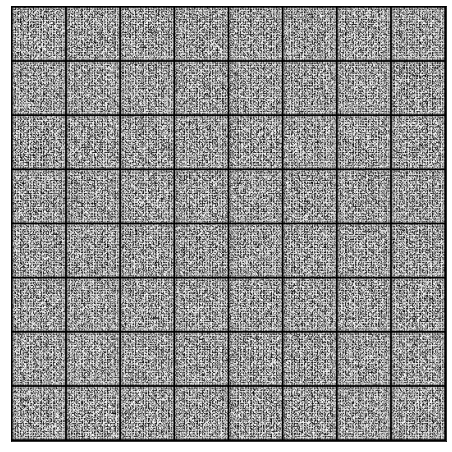

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = '/content/drive/MyDrive/Junior Year/Spring/IW06/Code and Files/Generated Samples'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


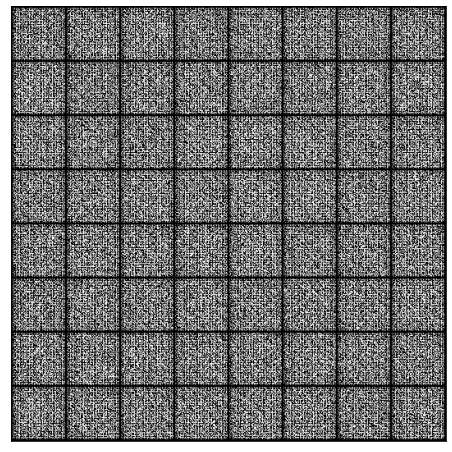

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.001
epochs = 150

In [ ]:
history = fit(epochs,lr)


Epoch [1/150], loss_g: 6.1766, loss_d: 1.5095, real_score: 0.4429, fake_score: 0.4834
Saving generated-images-0001.png



Epoch [2/150], loss_g: 16.5416, loss_d: 6.5630, real_score: 1.0000, fake_score: 0.9984
Saving generated-images-0002.png



Epoch [3/150], loss_g: 10.2415, loss_d: 1.3045, real_score: 0.3880, fake_score: 0.0000
Saving generated-images-0003.png



Epoch [4/150], loss_g: 5.0920, loss_d: 0.0332, real_score: 1.0000, fake_score: 0.0325
Saving generated-images-0004.png



Epoch [5/150], loss_g: 13.5736, loss_d: 4.1851, real_score: 1.0000, fake_score: 0.9825
Saving generated-images-0005.png



Epoch [6/150], loss_g: 14.1960, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-0006.png



Epoch [7/150], loss_g: 13.9792, loss_d: 0.0071, real_score: 0.9933, fake_score: 0.0000
Saving generated-images-0007.png



Epoch [8/150], loss_g: 13.2893, loss_d: 0.0261, real_score: 0.9789, fake_score: 0.0000
Saving generated-images-0008.png



Epoch [9/150], loss_g: 12.0604, loss_d: 0.0334, real_score: 0.9738, fake_score: 0.0000
Saving generated-images-0009.png



Epoch [10/150], loss_g: 10.7075, loss_d: 0.0243, real_score: 0.9794, fake_score: 0.0000
Saving generated-images-0010.png



Epoch [11/150], loss_g: 7.7137, loss_d: 0.0146, real_score: 0.9871, fake_score: 0.0006
Saving generated-images-0011.png



Epoch [12/150], loss_g: 6.8941, loss_d: 0.0269, real_score: 0.9920, fake_score: 0.0183
Saving generated-images-0012.png



Epoch [13/150], loss_g: 17.6834, loss_d: 1.3109, real_score: 0.9936, fake_score: 0.5783
Saving generated-images-0013.png



Epoch [14/150], loss_g: 17.2559, loss_d: 0.5518, real_score: 0.6943, fake_score: 0.0000
Saving generated-images-0014.png



Epoch [15/150], loss_g: 16.2247, loss_d: 0.1076, real_score: 0.9262, fake_score: 0.0000
Saving generated-images-0015.png



Epoch [16/150], loss_g: 14.8469, loss_d: 0.0195, real_score: 0.9826, fake_score: 0.0000
Saving generated-images-0016.png



Epoch [17/150], loss_g: 12.5641, loss_d: 0.0063, real_score: 0.9939, fake_score: 0.0000
Saving generated-images-0017.png



Epoch [18/150], loss_g: 6.4381, loss_d: 0.0161, real_score: 0.9967, fake_score: 0.0124
Saving generated-images-0018.png



Epoch [19/150], loss_g: 14.8010, loss_d: 2.4470, real_score: 0.9975, fake_score: 0.7698
Saving generated-images-0019.png



Epoch [20/150], loss_g: 12.7730, loss_d: 0.8271, real_score: 0.5088, fake_score: 0.0000
Saving generated-images-0020.png



Epoch [21/150], loss_g: 10.0445, loss_d: 0.0267, real_score: 0.9748, fake_score: 0.0001
Saving generated-images-0021.png



Epoch [22/150], loss_g: 5.7111, loss_d: 0.0098, real_score: 0.9970, fake_score: 0.0067
Saving generated-images-0022.png



Epoch [23/150], loss_g: 10.6362, loss_d: 0.3714, real_score: 0.9988, fake_score: 0.2593
Saving generated-images-0023.png



Epoch [24/150], loss_g: 11.1814, loss_d: 0.0055, real_score: 0.9953, fake_score: 0.0008
Saving generated-images-0024.png



Epoch [25/150], loss_g: 10.4439, loss_d: 0.0113, real_score: 0.9893, fake_score: 0.0004
Saving generated-images-0025.png



Epoch [26/150], loss_g: 8.4412, loss_d: 0.0157, real_score: 0.9864, fake_score: 0.0017
Saving generated-images-0026.png



Epoch [27/150], loss_g: 7.2226, loss_d: 0.0745, real_score: 0.9885, fake_score: 0.0577
Saving generated-images-0027.png



Epoch [28/150], loss_g: 12.1621, loss_d: 0.2628, real_score: 0.9866, fake_score: 0.1934
Saving generated-images-0028.png



Epoch [29/150], loss_g: 10.9301, loss_d: 0.0840, real_score: 0.9265, fake_score: 0.0007
Saving generated-images-0029.png



Epoch [30/150], loss_g: 7.7207, loss_d: 0.0329, real_score: 0.9703, fake_score: 0.0017
Saving generated-images-0030.png



Epoch [31/150], loss_g: 5.1760, loss_d: 0.0379, real_score: 0.9919, fake_score: 0.0288
Saving generated-images-0031.png



Epoch [32/150], loss_g: 11.3049, loss_d: 0.4864, real_score: 0.9957, fake_score: 0.3341
Saving generated-images-0032.png



Epoch [33/150], loss_g: 10.2470, loss_d: 0.2692, real_score: 0.7899, fake_score: 0.0006
Saving generated-images-0033.png



Epoch [34/150], loss_g: 8.0536, loss_d: 0.0040, real_score: 0.9975, fake_score: 0.0014
Saving generated-images-0034.png



Epoch [35/150], loss_g: 5.1034, loss_d: 0.0144, real_score: 0.9996, fake_score: 0.0139
Saving generated-images-0035.png



Epoch [36/150], loss_g: 10.9709, loss_d: 0.5312, real_score: 0.9998, fake_score: 0.3487
Saving generated-images-0036.png



Epoch [37/150], loss_g: 10.4893, loss_d: 0.0977, real_score: 0.9161, fake_score: 0.0016
Saving generated-images-0037.png



Epoch [38/150], loss_g: 9.3443, loss_d: 0.0474, real_score: 0.9577, fake_score: 0.0015
Saving generated-images-0038.png



Epoch [39/150], loss_g: 7.0441, loss_d: 0.0172, real_score: 0.9958, fake_score: 0.0128
Saving generated-images-0039.png



Epoch [40/150], loss_g: 11.1034, loss_d: 0.7942, real_score: 0.9986, fake_score: 0.4049
Saving generated-images-0040.png



Epoch [41/150], loss_g: 2.3886, loss_d: 4.7302, real_score: 0.0184, fake_score: 0.0001
Saving generated-images-0041.png



Epoch [42/150], loss_g: 5.2937, loss_d: 1.6114, real_score: 0.9995, fake_score: 0.5064
Saving generated-images-0042.png



Epoch [43/150], loss_g: 5.3376, loss_d: 0.2366, real_score: 0.9271, fake_score: 0.1321
Saving generated-images-0043.png



Epoch [44/150], loss_g: 4.8205, loss_d: 0.1251, real_score: 0.9859, fake_score: 0.0998
Saving generated-images-0044.png



Epoch [45/150], loss_g: 4.4162, loss_d: 0.1587, real_score: 0.9904, fake_score: 0.1292
Saving generated-images-0045.png



Epoch [46/150], loss_g: 8.0593, loss_d: 0.6685, real_score: 0.9830, fake_score: 0.3732
Saving generated-images-0046.png



Epoch [47/150], loss_g: 2.6971, loss_d: 2.1158, real_score: 0.1883, fake_score: 0.0054
Saving generated-images-0047.png



Epoch [48/150], loss_g: 5.2708, loss_d: 1.1738, real_score: 0.9999, fake_score: 0.4841
Saving generated-images-0048.png



Epoch [49/150], loss_g: 5.2985, loss_d: 0.0318, real_score: 0.9997, fake_score: 0.0308
Saving generated-images-0049.png



Epoch [50/150], loss_g: 5.1539, loss_d: 0.0642, real_score: 0.9992, fake_score: 0.0592
Saving generated-images-0050.png



Epoch [51/150], loss_g: 8.0303, loss_d: 1.3815, real_score: 0.9984, fake_score: 0.4527
Saving generated-images-0051.png



Epoch [52/150], loss_g: 4.6519, loss_d: 1.4750, real_score: 0.3209, fake_score: 0.0167
Saving generated-images-0052.png



Epoch [53/150], loss_g: 2.8305, loss_d: 0.3750, real_score: 0.9994, fake_score: 0.2743
Saving generated-images-0053.png



Epoch [54/150], loss_g: 10.4528, loss_d: 3.7258, real_score: 0.9996, fake_score: 0.8284
Saving generated-images-0054.png



Epoch [55/150], loss_g: 4.0410, loss_d: 1.4160, real_score: 0.3607, fake_score: 0.0107
Saving generated-images-0055.png



Epoch [56/150], loss_g: 4.6083, loss_d: 0.3666, real_score: 0.9688, fake_score: 0.2177
Saving generated-images-0056.png



Epoch [57/150], loss_g: 4.6910, loss_d: 0.1955, real_score: 0.9326, fake_score: 0.1020
Saving generated-images-0057.png



Epoch [58/150], loss_g: 3.6994, loss_d: 0.2391, real_score: 0.8504, fake_score: 0.0552
Saving generated-images-0058.png



Epoch [59/150], loss_g: 5.6951, loss_d: 0.5371, real_score: 0.9439, fake_score: 0.3046
Saving generated-images-0059.png



Epoch [60/150], loss_g: 1.4887, loss_d: 1.1051, real_score: 0.3940, fake_score: 0.0222
Saving generated-images-0060.png



Epoch [61/150], loss_g: 5.1898, loss_d: 2.2293, real_score: 0.9981, fake_score: 0.6432
Saving generated-images-0061.png



Epoch [62/150], loss_g: 5.6467, loss_d: 0.1298, real_score: 0.9188, fake_score: 0.0323
Saving generated-images-0062.png



Epoch [63/150], loss_g: 4.1256, loss_d: 0.3435, real_score: 0.7850, fake_score: 0.0310
Saving generated-images-0063.png



Epoch [64/150], loss_g: 3.2142, loss_d: 0.2051, real_score: 0.9552, fake_score: 0.1382
Saving generated-images-0064.png



Epoch [65/150], loss_g: 6.2279, loss_d: 0.5029, real_score: 0.9734, fake_score: 0.3462
Saving generated-images-0065.png



Epoch [66/150], loss_g: 4.9812, loss_d: 0.3415, real_score: 0.7583, fake_score: 0.0152
Saving generated-images-0066.png



Epoch [67/150], loss_g: 5.5967, loss_d: 0.2658, real_score: 0.9589, fake_score: 0.1828
Saving generated-images-0067.png



Epoch [68/150], loss_g: 7.6489, loss_d: 0.2486, real_score: 0.9274, fake_score: 0.1418
Saving generated-images-0068.png



Epoch [69/150], loss_g: 3.3166, loss_d: 0.5045, real_score: 0.6606, fake_score: 0.0053
Saving generated-images-0069.png



Epoch [70/150], loss_g: 13.2736, loss_d: 1.6813, real_score: 0.9971, fake_score: 0.6678
Saving generated-images-0070.png



Epoch [71/150], loss_g: 6.9805, loss_d: 3.6063, real_score: 0.0485, fake_score: 0.0002
Saving generated-images-0071.png



Epoch [72/150], loss_g: 2.0206, loss_d: 0.0163, real_score: 0.9971, fake_score: 0.0132
Saving generated-images-0072.png



Epoch [73/150], loss_g: 4.5321, loss_d: 3.0322, real_score: 0.9990, fake_score: 0.7451
Saving generated-images-0073.png



Epoch [74/150], loss_g: 5.8632, loss_d: 0.1190, real_score: 0.9400, fake_score: 0.0480
Saving generated-images-0074.png



Epoch [75/150], loss_g: 4.9858, loss_d: 0.4557, real_score: 0.6969, fake_score: 0.0172
Saving generated-images-0075.png



Epoch [76/150], loss_g: 4.1771, loss_d: 0.0726, real_score: 0.9654, fake_score: 0.0353
Saving generated-images-0076.png



Epoch [77/150], loss_g: 3.6882, loss_d: 0.0787, real_score: 0.9905, fake_score: 0.0657
Saving generated-images-0077.png



Epoch [78/150], loss_g: 3.4122, loss_d: 0.1508, real_score: 0.9939, fake_score: 0.1306
Saving generated-images-0078.png



Epoch [79/150], loss_g: 5.0119, loss_d: 0.2602, real_score: 0.9920, fake_score: 0.2148
Saving generated-images-0079.png



Epoch [80/150], loss_g: 5.6255, loss_d: 0.0737, real_score: 0.9709, fake_score: 0.0416
Saving generated-images-0080.png



Epoch [81/150], loss_g: 5.4323, loss_d: 0.0981, real_score: 0.9459, fake_score: 0.0369
Saving generated-images-0081.png



Epoch [82/150], loss_g: 7.4267, loss_d: 0.1921, real_score: 0.9522, fake_score: 0.1234
Saving generated-images-0082.png



Epoch [83/150], loss_g: 6.8451, loss_d: 0.1030, real_score: 0.9285, fake_score: 0.0222
Saving generated-images-0083.png



Epoch [84/150], loss_g: 16.2879, loss_d: 0.4723, real_score: 0.9621, fake_score: 0.3283
Saving generated-images-0084.png



Epoch [85/150], loss_g: 9.3498, loss_d: 1.9952, real_score: 0.1858, fake_score: 0.0000
Saving generated-images-0085.png



Epoch [86/150], loss_g: 2.0870, loss_d: 0.0107, real_score: 0.9974, fake_score: 0.0080
Saving generated-images-0086.png



Epoch [87/150], loss_g: 11.7684, loss_d: 3.6769, real_score: 0.9988, fake_score: 0.8801
Saving generated-images-0087.png



Epoch [88/150], loss_g: 11.3642, loss_d: 0.1466, real_score: 0.8802, fake_score: 0.0002
Saving generated-images-0088.png



Epoch [89/150], loss_g: 8.6963, loss_d: 0.8722, real_score: 0.5192, fake_score: 0.0003
Saving generated-images-0089.png



Epoch [90/150], loss_g: 7.0517, loss_d: 0.0101, real_score: 0.9932, fake_score: 0.0032
Saving generated-images-0090.png



Epoch [91/150], loss_g: 5.4218, loss_d: 0.0102, real_score: 0.9986, fake_score: 0.0087
Saving generated-images-0091.png



Epoch [92/150], loss_g: 4.3588, loss_d: 0.0552, real_score: 0.9992, fake_score: 0.0521
Saving generated-images-0092.png



Epoch [93/150], loss_g: 5.0567, loss_d: 0.2839, real_score: 0.9994, fake_score: 0.1920
Saving generated-images-0093.png



Epoch [94/150], loss_g: 5.7793, loss_d: 0.0197, real_score: 0.9983, fake_score: 0.0177
Saving generated-images-0094.png



Epoch [95/150], loss_g: 5.5248, loss_d: 0.0204, real_score: 0.9965, fake_score: 0.0167
Saving generated-images-0095.png



Epoch [96/150], loss_g: 4.8265, loss_d: 0.0674, real_score: 0.9948, fake_score: 0.0580
Saving generated-images-0096.png



Epoch [97/150], loss_g: 9.6660, loss_d: 0.5254, real_score: 0.9916, fake_score: 0.2331
Saving generated-images-0097.png



Epoch [98/150], loss_g: 7.3436, loss_d: 0.4060, real_score: 0.7296, fake_score: 0.0076
Saving generated-images-0098.png



Epoch [99/150], loss_g: 6.3865, loss_d: 0.0246, real_score: 0.9896, fake_score: 0.0134
Saving generated-images-0099.png



Epoch [100/150], loss_g: 4.7486, loss_d: 0.0492, real_score: 0.9947, fake_score: 0.0417
Saving generated-images-0100.png



Epoch [101/150], loss_g: 5.8213, loss_d: 0.1714, real_score: 0.9948, fake_score: 0.1429
Saving generated-images-0101.png



Epoch [102/150], loss_g: 6.3038, loss_d: 0.0973, real_score: 0.9842, fake_score: 0.0713
Saving generated-images-0102.png



Epoch [103/150], loss_g: 6.1657, loss_d: 0.1531, real_score: 0.9617, fake_score: 0.0917
Saving generated-images-0103.png



Epoch [104/150], loss_g: 6.1047, loss_d: 0.1198, real_score: 0.9440, fake_score: 0.0486
Saving generated-images-0104.png



Epoch [105/150], loss_g: 7.7081, loss_d: 0.1187, real_score: 0.9776, fake_score: 0.0825
Saving generated-images-0105.png



Epoch [106/150], loss_g: 6.6660, loss_d: 0.0595, real_score: 0.9574, fake_score: 0.0121
Saving generated-images-0106.png



Epoch [107/150], loss_g: 5.4095, loss_d: 0.0540, real_score: 0.9740, fake_score: 0.0261
Saving generated-images-0107.png



Epoch [108/150], loss_g: 11.3888, loss_d: 0.1394, real_score: 0.9819, fake_score: 0.0950
Saving generated-images-0108.png



Epoch [109/150], loss_g: 0.0474, loss_d: 1.0539, real_score: 0.4782, fake_score: 0.0006
Saving generated-images-0109.png



Epoch [110/150], loss_g: 8.7630, loss_d: 4.3390, real_score: 0.9518, fake_score: 0.9698
Saving generated-images-0110.png



Epoch [111/150], loss_g: 2.9613, loss_d: 7.1309, real_score: 0.0023, fake_score: 0.0101
Saving generated-images-0111.png



Epoch [112/150], loss_g: 0.1139, loss_d: 1.6569, real_score: 0.3079, fake_score: 0.2213
Saving generated-images-0112.png



Epoch [113/150], loss_g: 0.7612, loss_d: 3.2079, real_score: 0.9883, fake_score: 0.9338
Saving generated-images-0113.png


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69dd6e7d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Epoch [114/150], loss_g: 3.6449, loss_d: 1.0349, real_score: 0.9231, fake_score: 0.5999
Saving generated-images-0114.png


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69dd6e7d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Epoch [115/150], loss_g: 1.7342, loss_d: 1.5112, real_score: 0.2727, fake_score: 0.0770
Saving generated-images-0115.png


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Epoch [116/150], loss_g: 1.5702, loss_d: 0.7247, real_score: 0.8221, fake_score: 0.3899
Saving generated-images-0116.png



Epoch [117/150], loss_g: 3.1069, loss_d: 0.8341, real_score: 0.8505, fake_score: 0.4678
Saving generated-images-0117.png



Epoch [118/150], loss_g: 1.5528, loss_d: 0.9111, real_score: 0.4880, fake_score: 0.1161
Saving generated-images-0118.png



Epoch [119/150], loss_g: 3.8091, loss_d: 0.6986, real_score: 0.8772, fake_score: 0.4191
Saving generated-images-0119.png



Epoch [120/150], loss_g: 2.5558, loss_d: 0.4855, real_score: 0.6785, fake_score: 0.0644
Saving generated-images-0120.png



Epoch [121/150], loss_g: 4.2849, loss_d: 0.4192, real_score: 0.9153, fake_score: 0.2769
Saving generated-images-0121.png



Epoch [122/150], loss_g: 3.8542, loss_d: 0.2543, real_score: 0.8298, fake_score: 0.0554
Saving generated-images-0122.png



Epoch [123/150], loss_g: 5.6321, loss_d: 0.3554, real_score: 0.9248, fake_score: 0.2306
Saving generated-images-0123.png



Epoch [124/150], loss_g: 1.5995, loss_d: 0.4773, real_score: 0.6810, fake_score: 0.0528
Saving generated-images-0124.png



Epoch [125/150], loss_g: 12.8241, loss_d: 2.1628, real_score: 0.9852, fake_score: 0.8762
Saving generated-images-0125.png



Epoch [126/150], loss_g: 6.1901, loss_d: 6.1720, real_score: 0.0045, fake_score: 0.0002
Saving generated-images-0126.png



Epoch [127/150], loss_g: 0.5257, loss_d: 0.6301, real_score: 0.6000, fake_score: 0.0258
Saving generated-images-0127.png



Epoch [128/150], loss_g: 3.1460, loss_d: 2.4168, real_score: 0.9909, fake_score: 0.8941
Saving generated-images-0128.png



Epoch [129/150], loss_g: 4.7341, loss_d: 0.5559, real_score: 0.8136, fake_score: 0.2615
Saving generated-images-0129.png



Epoch [130/150], loss_g: 0.8955, loss_d: 1.3210, real_score: 0.3482, fake_score: 0.0918
Saving generated-images-0130.png



Epoch [131/150], loss_g: 5.2525, loss_d: 1.7671, real_score: 0.9296, fake_score: 0.7919
Saving generated-images-0131.png



Epoch [132/150], loss_g: 1.0718, loss_d: 1.8469, real_score: 0.1984, fake_score: 0.0378
Saving generated-images-0132.png



Epoch [133/150], loss_g: 3.7970, loss_d: 1.8282, real_score: 0.9452, fake_score: 0.8092
Saving generated-images-0133.png



Epoch [134/150], loss_g: 1.7139, loss_d: 1.2050, real_score: 0.3905, fake_score: 0.1343
Saving generated-images-0134.png



Epoch [135/150], loss_g: 4.1064, loss_d: 0.9850, real_score: 0.9009, fake_score: 0.5611
Saving generated-images-0135.png



Epoch [136/150], loss_g: 1.0719, loss_d: 0.9571, real_score: 0.4519, fake_score: 0.0567
Saving generated-images-0136.png



Epoch [137/150], loss_g: 5.9889, loss_d: 1.6687, real_score: 0.9638, fake_score: 0.7887
Saving generated-images-0137.png



Epoch [138/150], loss_g: 1.1398, loss_d: 2.5414, real_score: 0.1063, fake_score: 0.0148
Saving generated-images-0138.png



Epoch [139/150], loss_g: 2.8688, loss_d: 1.3454, real_score: 0.9462, fake_score: 0.6970
Saving generated-images-0139.png



Epoch [140/150], loss_g: 3.2638, loss_d: 0.7732, real_score: 0.6900, fake_score: 0.2907
Saving generated-images-0140.png



Epoch [141/150], loss_g: 1.6656, loss_d: 0.9588, real_score: 0.5567, fake_score: 0.2560
Saving generated-images-0141.png



Epoch [142/150], loss_g: 6.2731, loss_d: 1.3164, real_score: 0.8447, fake_score: 0.6637
Saving generated-images-0142.png



Epoch [143/150], loss_g: 0.5476, loss_d: 2.8746, real_score: 0.0706, fake_score: 0.0067
Saving generated-images-0143.png



Epoch [144/150], loss_g: 4.4630, loss_d: 1.8756, real_score: 0.9716, fake_score: 0.8266
Saving generated-images-0144.png



Epoch [145/150], loss_g: 2.6059, loss_d: 0.8100, real_score: 0.5047, fake_score: 0.0447
Saving generated-images-0145.png



Epoch [146/150], loss_g: 2.1267, loss_d: 0.4687, real_score: 0.8370, fake_score: 0.2418
Saving generated-images-0146.png



Epoch [147/150], loss_g: 4.0618, loss_d: 0.5831, real_score: 0.8949, fake_score: 0.3657
Saving generated-images-0147.png



Epoch [148/150], loss_g: 2.2697, loss_d: 0.5614, real_score: 0.6468, fake_score: 0.0702
Saving generated-images-0148.png



Epoch [149/150], loss_g: 6.0483, loss_d: 0.8728, real_score: 0.9323, fake_score: 0.5302
Saving generated-images-0149.png



Epoch [150/150], loss_g: 0.2419, loss_d: 1.5349, real_score: 0.2692, fake_score: 0.0135
Saving generated-images-0150.png


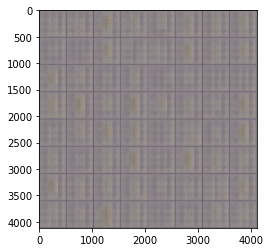

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/generated/generated-images-0010.png')
imgplot = plt.imshow(img)
plt.show()